# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size),
                                   transforms.ToTensor()])
    data = datasets.ImageFolder(data_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    return dataloader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [10]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

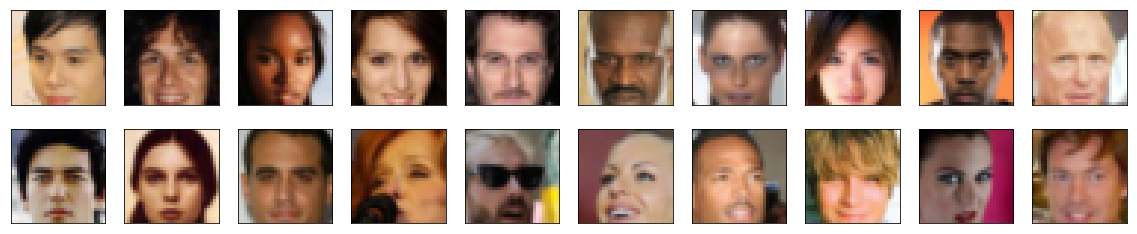

In [11]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [12]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_x, max_x = feature_range
    x = x * (max_x - min_x) + min_x
    return x


In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.9922)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Create a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [16]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # 32*32
        x = self.dropout(F.leaky_relu(self.conv1(x), 0.2))
        # 16*16
        x = self.dropout(F.leaky_relu(self.conv2(x), 0.2))
        # 8*8
        x = self.dropout(F.leaky_relu(self.conv3(x), 0.2))
        # 4*4
        
        x = x.view(-1, self.conv_dim*4*4*4)
        
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [17]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [18]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4) 
        # (batch_size, depth, 4, 4)
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        
        x = self.deconv3(x)
        x = torch.tanh(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [19]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [44]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), s

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [46]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       :param D_out: discriminator logits
       :param smooth: boolean for smootjing labels
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [47]:
import torch.optim as optim
# params
lr = 0.0002
beta1 = 0.1
beta2 = 0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [48]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.normal(0, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            # zero accumulated gradients
            d_optimizer.zero_grad()
            
            # move real images to gpu if available
            if train_on_gpu:
                real_images = real_images.cuda()
            # get output of discriminator for real image
            d_out = D(real_images)
            # calculate loss for real image
            d_real_loss = real_loss(d_out, smooth=True)
            
            ## generate fake images
            # generate latent vector
            z = np.random.normal(0, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move latent vector to gpu if available
            if train_on_gpu:
                z = z.cuda()
            # generate fake images
            fake_images = G(z)
            # get output of discriminator for fake images
            d_out = D(fake_images)
            # calculate loss for fake images
            d_fake_loss = fake_loss(d_out)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            
            # 2. Train the generator with an adversarial loss
            
            # zero accumulated gradients
            g_optimizer.zero_grad()
            
            # generate latent vector
            z = np.random.normal(0, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move latent vector to gpu if available
            if train_on_gpu:
                z = z.cuda()
            # generate fake images
            generated_images = G(z)
            
            # get output of discriminator on generated images
            d_out = D(generated_images)
            # compute the discriminator losses on generated images using flipped labels
            g_loss = real_loss(d_out)
            
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [49]:
# set number of epochs 
n_epochs = 20


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.6074 | g_loss: 1.0151
Epoch [    1/   20] | d_loss: 0.4764 | g_loss: 3.2685
Epoch [    1/   20] | d_loss: 0.5602 | g_loss: 3.2865
Epoch [    1/   20] | d_loss: 0.6417 | g_loss: 1.9624
Epoch [    1/   20] | d_loss: 0.9027 | g_loss: 3.1443
Epoch [    1/   20] | d_loss: 0.8081 | g_loss: 2.6850
Epoch [    1/   20] | d_loss: 0.9565 | g_loss: 2.3474
Epoch [    1/   20] | d_loss: 0.7489 | g_loss: 2.0068
Epoch [    1/   20] | d_loss: 0.9484 | g_loss: 1.1289
Epoch [    1/   20] | d_loss: 1.1446 | g_loss: 0.9577
Epoch [    1/   20] | d_loss: 1.0241 | g_loss: 1.4209
Epoch [    1/   20] | d_loss: 1.2017 | g_loss: 1.4428
Epoch [    1/   20] | d_loss: 1.0777 | g_loss: 1.1299
Epoch [    1/   20] | d_loss: 0.9519 | g_loss: 1.3427
Epoch [    1/   20] | d_loss: 1.0322 | g_loss: 2.3669
Epoch [    1/   20] | d_loss: 0.9246 | g_loss: 1.4950
Epoch [    1/   20] | d_loss: 1.0711 | g_loss: 1.2498
Epoch [    1/   20] | d_loss: 1.0680 | g_loss: 0.6344
Epoch [    1/   20] | d_loss

Epoch [    2/   20] | d_loss: 1.3136 | g_loss: 1.3620
Epoch [    2/   20] | d_loss: 1.0280 | g_loss: 1.0847
Epoch [    2/   20] | d_loss: 1.3847 | g_loss: 0.8014
Epoch [    2/   20] | d_loss: 1.2766 | g_loss: 1.2075
Epoch [    2/   20] | d_loss: 1.1654 | g_loss: 1.2190
Epoch [    2/   20] | d_loss: 1.2515 | g_loss: 1.2307
Epoch [    2/   20] | d_loss: 1.1198 | g_loss: 0.8911
Epoch [    2/   20] | d_loss: 1.3436 | g_loss: 1.1200
Epoch [    2/   20] | d_loss: 1.3155 | g_loss: 0.7872
Epoch [    2/   20] | d_loss: 1.3699 | g_loss: 1.1118
Epoch [    2/   20] | d_loss: 1.2301 | g_loss: 1.3394
Epoch [    2/   20] | d_loss: 1.0032 | g_loss: 1.1741
Epoch [    2/   20] | d_loss: 1.1808 | g_loss: 0.9962
Epoch [    2/   20] | d_loss: 1.1599 | g_loss: 1.0350
Epoch [    2/   20] | d_loss: 1.4442 | g_loss: 0.6442
Epoch [    2/   20] | d_loss: 1.3326 | g_loss: 1.1951
Epoch [    2/   20] | d_loss: 1.3673 | g_loss: 0.9106
Epoch [    2/   20] | d_loss: 1.3200 | g_loss: 0.9746
Epoch [    2/   20] | d_loss

Epoch [    4/   20] | d_loss: 1.2229 | g_loss: 1.0282
Epoch [    4/   20] | d_loss: 1.2857 | g_loss: 1.0082
Epoch [    4/   20] | d_loss: 1.1425 | g_loss: 1.1258
Epoch [    4/   20] | d_loss: 1.3856 | g_loss: 1.0203
Epoch [    4/   20] | d_loss: 1.3815 | g_loss: 1.0181
Epoch [    4/   20] | d_loss: 1.1105 | g_loss: 1.2232
Epoch [    4/   20] | d_loss: 1.1865 | g_loss: 1.1703
Epoch [    4/   20] | d_loss: 1.1066 | g_loss: 1.4446
Epoch [    4/   20] | d_loss: 1.3241 | g_loss: 0.8699
Epoch [    4/   20] | d_loss: 1.2358 | g_loss: 0.8947
Epoch [    4/   20] | d_loss: 1.0959 | g_loss: 0.7186
Epoch [    4/   20] | d_loss: 1.3484 | g_loss: 0.8756
Epoch [    4/   20] | d_loss: 1.0437 | g_loss: 1.0741
Epoch [    4/   20] | d_loss: 1.2899 | g_loss: 1.1300
Epoch [    4/   20] | d_loss: 1.0698 | g_loss: 1.0920
Epoch [    4/   20] | d_loss: 1.1393 | g_loss: 1.2373
Epoch [    4/   20] | d_loss: 1.2234 | g_loss: 0.5963
Epoch [    4/   20] | d_loss: 1.4195 | g_loss: 0.9934
Epoch [    4/   20] | d_loss

Epoch [    6/   20] | d_loss: 1.1774 | g_loss: 1.0210
Epoch [    6/   20] | d_loss: 1.2410 | g_loss: 0.8970
Epoch [    6/   20] | d_loss: 1.3150 | g_loss: 0.7792
Epoch [    6/   20] | d_loss: 1.1880 | g_loss: 1.1629
Epoch [    6/   20] | d_loss: 1.4163 | g_loss: 1.1737
Epoch [    6/   20] | d_loss: 1.1417 | g_loss: 1.2419
Epoch [    6/   20] | d_loss: 1.3107 | g_loss: 1.2460
Epoch [    6/   20] | d_loss: 0.9728 | g_loss: 1.2422
Epoch [    6/   20] | d_loss: 1.4629 | g_loss: 1.2218
Epoch [    6/   20] | d_loss: 1.2262 | g_loss: 1.1457
Epoch [    6/   20] | d_loss: 1.2509 | g_loss: 1.0181
Epoch [    6/   20] | d_loss: 1.3333 | g_loss: 0.9873
Epoch [    6/   20] | d_loss: 1.3170 | g_loss: 0.8174
Epoch [    6/   20] | d_loss: 1.0651 | g_loss: 0.8749
Epoch [    6/   20] | d_loss: 1.2052 | g_loss: 1.0340
Epoch [    6/   20] | d_loss: 1.3917 | g_loss: 1.1457
Epoch [    6/   20] | d_loss: 1.3039 | g_loss: 1.4600
Epoch [    6/   20] | d_loss: 1.1868 | g_loss: 1.0338
Epoch [    6/   20] | d_loss

Epoch [    7/   20] | d_loss: 1.0917 | g_loss: 1.1629
Epoch [    7/   20] | d_loss: 1.2331 | g_loss: 0.8565
Epoch [    7/   20] | d_loss: 1.2721 | g_loss: 0.8524
Epoch [    7/   20] | d_loss: 1.2150 | g_loss: 1.2185
Epoch [    7/   20] | d_loss: 1.3216 | g_loss: 1.0586
Epoch [    7/   20] | d_loss: 1.3531 | g_loss: 0.9846
Epoch [    7/   20] | d_loss: 1.3222 | g_loss: 1.1023
Epoch [    7/   20] | d_loss: 1.2226 | g_loss: 0.9631
Epoch [    7/   20] | d_loss: 1.2874 | g_loss: 1.1512
Epoch [    7/   20] | d_loss: 1.0954 | g_loss: 1.4032
Epoch [    7/   20] | d_loss: 1.2371 | g_loss: 1.4831
Epoch [    7/   20] | d_loss: 1.1548 | g_loss: 1.0834
Epoch [    7/   20] | d_loss: 1.1860 | g_loss: 0.8843
Epoch [    7/   20] | d_loss: 1.2740 | g_loss: 0.9452
Epoch [    7/   20] | d_loss: 1.0232 | g_loss: 1.3724
Epoch [    7/   20] | d_loss: 1.3535 | g_loss: 0.8751
Epoch [    7/   20] | d_loss: 1.3741 | g_loss: 0.7118
Epoch [    7/   20] | d_loss: 1.0310 | g_loss: 0.9402
Epoch [    7/   20] | d_loss

Epoch [    9/   20] | d_loss: 1.0487 | g_loss: 0.9710
Epoch [    9/   20] | d_loss: 1.2557 | g_loss: 1.2444
Epoch [    9/   20] | d_loss: 1.2515 | g_loss: 1.0795
Epoch [    9/   20] | d_loss: 1.0470 | g_loss: 1.1980
Epoch [    9/   20] | d_loss: 1.1338 | g_loss: 1.3976
Epoch [    9/   20] | d_loss: 1.0505 | g_loss: 0.9061
Epoch [    9/   20] | d_loss: 1.5146 | g_loss: 0.9371
Epoch [    9/   20] | d_loss: 1.2820 | g_loss: 1.2379
Epoch [    9/   20] | d_loss: 1.2145 | g_loss: 0.9731
Epoch [    9/   20] | d_loss: 1.3885 | g_loss: 1.2259
Epoch [    9/   20] | d_loss: 1.1368 | g_loss: 1.2290
Epoch [    9/   20] | d_loss: 1.2782 | g_loss: 1.2651
Epoch [    9/   20] | d_loss: 0.9960 | g_loss: 0.9703
Epoch [    9/   20] | d_loss: 0.9971 | g_loss: 1.1216
Epoch [    9/   20] | d_loss: 1.2060 | g_loss: 0.7784
Epoch [    9/   20] | d_loss: 1.2375 | g_loss: 0.9666
Epoch [    9/   20] | d_loss: 1.1279 | g_loss: 1.0073
Epoch [    9/   20] | d_loss: 1.0477 | g_loss: 1.3602
Epoch [    9/   20] | d_loss

Epoch [   11/   20] | d_loss: 1.3125 | g_loss: 1.3006
Epoch [   11/   20] | d_loss: 1.0806 | g_loss: 1.7397
Epoch [   11/   20] | d_loss: 1.4453 | g_loss: 1.1241
Epoch [   11/   20] | d_loss: 0.7291 | g_loss: 1.7317
Epoch [   11/   20] | d_loss: 1.2230 | g_loss: 1.6369
Epoch [   11/   20] | d_loss: 1.6170 | g_loss: 0.8096
Epoch [   11/   20] | d_loss: 1.2781 | g_loss: 0.9567
Epoch [   11/   20] | d_loss: 1.2656 | g_loss: 1.0643
Epoch [   11/   20] | d_loss: 1.0334 | g_loss: 0.6280
Epoch [   11/   20] | d_loss: 1.5798 | g_loss: 1.1079
Epoch [   11/   20] | d_loss: 1.0018 | g_loss: 1.2648
Epoch [   11/   20] | d_loss: 1.6184 | g_loss: 1.6129
Epoch [   11/   20] | d_loss: 0.8639 | g_loss: 1.4839
Epoch [   11/   20] | d_loss: 1.4694 | g_loss: 1.1936
Epoch [   11/   20] | d_loss: 1.2198 | g_loss: 1.6635
Epoch [   11/   20] | d_loss: 1.1139 | g_loss: 0.8823
Epoch [   11/   20] | d_loss: 1.1554 | g_loss: 1.5513
Epoch [   11/   20] | d_loss: 1.0778 | g_loss: 1.1870
Epoch [   11/   20] | d_loss

Epoch [   12/   20] | d_loss: 0.8672 | g_loss: 1.1065
Epoch [   12/   20] | d_loss: 1.3322 | g_loss: 1.3378
Epoch [   12/   20] | d_loss: 0.8398 | g_loss: 1.8572
Epoch [   12/   20] | d_loss: 1.1220 | g_loss: 1.1962
Epoch [   12/   20] | d_loss: 0.9850 | g_loss: 1.3885
Epoch [   12/   20] | d_loss: 1.2313 | g_loss: 0.9231
Epoch [   12/   20] | d_loss: 0.7504 | g_loss: 1.8194
Epoch [   12/   20] | d_loss: 1.1290 | g_loss: 1.2005
Epoch [   12/   20] | d_loss: 1.0495 | g_loss: 1.5195
Epoch [   12/   20] | d_loss: 1.1748 | g_loss: 0.7742
Epoch [   12/   20] | d_loss: 0.8343 | g_loss: 1.5069
Epoch [   12/   20] | d_loss: 1.0102 | g_loss: 1.4029
Epoch [   12/   20] | d_loss: 0.8332 | g_loss: 1.9623
Epoch [   12/   20] | d_loss: 1.0214 | g_loss: 1.0773
Epoch [   12/   20] | d_loss: 1.3111 | g_loss: 1.1769
Epoch [   12/   20] | d_loss: 1.1482 | g_loss: 1.1289
Epoch [   13/   20] | d_loss: 1.2616 | g_loss: 1.4208
Epoch [   13/   20] | d_loss: 1.0546 | g_loss: 1.2970
Epoch [   13/   20] | d_loss

Epoch [   14/   20] | d_loss: 1.1173 | g_loss: 2.1651
Epoch [   14/   20] | d_loss: 0.7539 | g_loss: 1.5199
Epoch [   14/   20] | d_loss: 1.3886 | g_loss: 0.8612
Epoch [   14/   20] | d_loss: 1.2017 | g_loss: 1.2232
Epoch [   14/   20] | d_loss: 1.0581 | g_loss: 1.5272
Epoch [   14/   20] | d_loss: 1.0659 | g_loss: 2.0051
Epoch [   14/   20] | d_loss: 1.1880 | g_loss: 1.3807
Epoch [   14/   20] | d_loss: 0.9093 | g_loss: 1.5526
Epoch [   14/   20] | d_loss: 0.8657 | g_loss: 1.3894
Epoch [   14/   20] | d_loss: 1.1479 | g_loss: 1.2692
Epoch [   14/   20] | d_loss: 0.8962 | g_loss: 1.6178
Epoch [   14/   20] | d_loss: 1.3428 | g_loss: 1.4965
Epoch [   14/   20] | d_loss: 1.0730 | g_loss: 1.5468
Epoch [   14/   20] | d_loss: 0.9389 | g_loss: 1.3857
Epoch [   14/   20] | d_loss: 0.9610 | g_loss: 2.2412
Epoch [   14/   20] | d_loss: 1.4005 | g_loss: 1.5344
Epoch [   14/   20] | d_loss: 1.4144 | g_loss: 1.0764
Epoch [   14/   20] | d_loss: 1.4215 | g_loss: 1.6481
Epoch [   14/   20] | d_loss

Epoch [   16/   20] | d_loss: 1.0233 | g_loss: 1.8443
Epoch [   16/   20] | d_loss: 1.0236 | g_loss: 1.0587
Epoch [   16/   20] | d_loss: 1.2523 | g_loss: 1.1812
Epoch [   16/   20] | d_loss: 1.1592 | g_loss: 1.8258
Epoch [   16/   20] | d_loss: 1.0752 | g_loss: 1.6751
Epoch [   16/   20] | d_loss: 1.4426 | g_loss: 1.7377
Epoch [   16/   20] | d_loss: 0.7056 | g_loss: 1.2365
Epoch [   16/   20] | d_loss: 1.0286 | g_loss: 0.9844
Epoch [   16/   20] | d_loss: 0.8411 | g_loss: 1.4954
Epoch [   16/   20] | d_loss: 0.9395 | g_loss: 1.7394
Epoch [   16/   20] | d_loss: 1.0651 | g_loss: 1.1887
Epoch [   16/   20] | d_loss: 0.9916 | g_loss: 1.1708
Epoch [   16/   20] | d_loss: 1.1059 | g_loss: 1.2040
Epoch [   16/   20] | d_loss: 1.3818 | g_loss: 1.7649
Epoch [   16/   20] | d_loss: 1.0727 | g_loss: 1.3678
Epoch [   16/   20] | d_loss: 0.9420 | g_loss: 1.5083
Epoch [   16/   20] | d_loss: 1.0476 | g_loss: 1.6748
Epoch [   16/   20] | d_loss: 0.8472 | g_loss: 2.0271
Epoch [   16/   20] | d_loss

Epoch [   17/   20] | d_loss: 1.0828 | g_loss: 1.8761
Epoch [   17/   20] | d_loss: 1.0594 | g_loss: 1.7879
Epoch [   17/   20] | d_loss: 1.2603 | g_loss: 1.0908
Epoch [   17/   20] | d_loss: 1.2404 | g_loss: 1.2605
Epoch [   17/   20] | d_loss: 1.0835 | g_loss: 1.6830
Epoch [   17/   20] | d_loss: 0.9683 | g_loss: 1.6983
Epoch [   17/   20] | d_loss: 1.3206 | g_loss: 2.1615
Epoch [   17/   20] | d_loss: 0.9134 | g_loss: 1.4849
Epoch [   17/   20] | d_loss: 1.0532 | g_loss: 1.4102
Epoch [   17/   20] | d_loss: 1.0080 | g_loss: 1.7750
Epoch [   18/   20] | d_loss: 0.9947 | g_loss: 1.8466
Epoch [   18/   20] | d_loss: 1.2554 | g_loss: 1.1726
Epoch [   18/   20] | d_loss: 1.1995 | g_loss: 1.1116
Epoch [   18/   20] | d_loss: 1.0960 | g_loss: 1.6030
Epoch [   18/   20] | d_loss: 1.1375 | g_loss: 1.9225
Epoch [   18/   20] | d_loss: 1.2108 | g_loss: 1.2404
Epoch [   18/   20] | d_loss: 0.9087 | g_loss: 1.2015
Epoch [   18/   20] | d_loss: 0.8537 | g_loss: 1.4261
Epoch [   18/   20] | d_loss

Epoch [   19/   20] | d_loss: 1.0699 | g_loss: 1.4743
Epoch [   19/   20] | d_loss: 0.8041 | g_loss: 1.3414
Epoch [   19/   20] | d_loss: 0.8255 | g_loss: 1.3784
Epoch [   19/   20] | d_loss: 0.9275 | g_loss: 1.5558
Epoch [   19/   20] | d_loss: 1.4307 | g_loss: 1.4847
Epoch [   19/   20] | d_loss: 1.0745 | g_loss: 1.5638
Epoch [   19/   20] | d_loss: 0.8732 | g_loss: 1.6827
Epoch [   19/   20] | d_loss: 0.8956 | g_loss: 1.1872
Epoch [   19/   20] | d_loss: 0.9815 | g_loss: 1.0229
Epoch [   19/   20] | d_loss: 1.0053 | g_loss: 1.2183
Epoch [   19/   20] | d_loss: 0.6405 | g_loss: 1.7218
Epoch [   19/   20] | d_loss: 0.7779 | g_loss: 1.9868
Epoch [   19/   20] | d_loss: 0.9405 | g_loss: 2.7354
Epoch [   19/   20] | d_loss: 1.1868 | g_loss: 0.5036
Epoch [   19/   20] | d_loss: 1.4053 | g_loss: 1.2820
Epoch [   19/   20] | d_loss: 0.9470 | g_loss: 1.3341
Epoch [   19/   20] | d_loss: 1.3035 | g_loss: 1.3358
Epoch [   19/   20] | d_loss: 1.4318 | g_loss: 1.0677
Epoch [   19/   20] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

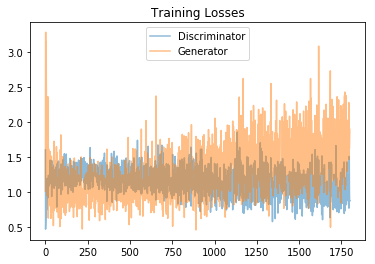

In [50]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [51]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [52]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

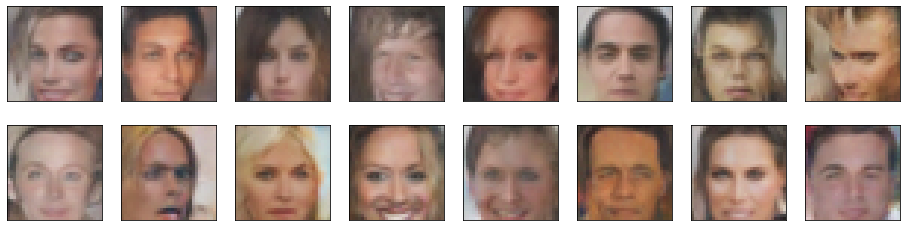

In [53]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
* The samples generated are very noisy because we took only 32*32 images which probably get rid of many important features 
* As the dataset is biased it is mostly creating white or brownish faces most common for celebrities and also it is only creating happy smiling faces which is most common for celebrities as well 
* Number of epochs is 20 and I don't think it has reached it's plateu as both discriminator and generator has a lot of up and down tendency at that point. We could have trained for around 100 epochs and probably then it would have been a little better
* The netwrok is not deep enough for this kind of complicated task, probably creating tywice deeper netwrok would have been better.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.